In [15]:
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import capnp
import viewer 
import pandas as pd
import seaborn as sns
import re

## What is a Hit File?

**Hit files** are the resulting output files generated by software tools like `seticore`, which is used to process data for (SETI). These files contain a list of detected hits along with various attributes that describe each hit.

### Some Contents of a Hit File

- **frequency**: The frequency at which the hit was detected.
- **snr**: The signal-to-noise ratio of the hit, indicating its strength relative to the background noise.
- **drift_rate**: The rate at which the frequency of the signal changes over time, measured in Hz/s.
- **beam**: The beam number or identifier, indicating which beam of the telescope array detected the hit.

### Example Hit File

### Loading in a hits file to a Pandas dataframe

In [16]:
#Make the pandas dataframe
hit_capnp = capnp.load('/mnt_home/mayalaidler/seticore/hit.capnp')

# Define a function to read the .hits file
def read_hits(filename):
    with open(filename, 'rb') as f:
        hits = hit_capnp.Hit.read_multiple(f)
        data = [hit.to_dict()['filterbank'] for hit in hits]
        f.seek(0,0)
        hits = hit_capnp.Hit.read_multiple(f)
        data2 = [hit.to_dict()['signal'] for hit in hits]
        d = pd.DataFrame(data)
        d2 = pd.DataFrame(data2)
        d3 = pd.concat([d, d2], axis = 1, join = 'outer')
    return d3

### Load the JWST hits file and load the first five rows

In [17]:
# Load the .hits file as a pandas DataFrame
fn03 = '/datax/scratch/danielc/jwst-test-data/jwst-may-20/guppi_60450_05861_003791_JWST_0001.hits'

df3 = read_hits(fn03)
print('first five rows: ', df3.head())
print('column names: ', df3.keys())

first five rows:    sourceName         fch1      foff        tstart     tsamp         ra  \
0       JWST  2269.450183  0.000002  60450.067839  4.908534  17.570128   
1       JWST  2269.487214  0.000002  60450.067839  4.908534  17.570128   
2       JWST  2269.513985  0.000002  60450.067839  4.908534  17.570128   
3       JWST  2269.527237  0.000002  60450.067839  4.908534  17.570128   
4       JWST  2269.535214  0.000002  60450.067839  4.908534  17.570128   

        dec  telescopeId  numTimesteps  numChannels  ...    frequency  index  \
0 -29.15975           64            59          113  ...  2269.450304  15870   
1 -29.15975           64            59          115  ...  2269.487338  38593   
2 -29.15975           64            59          114  ...  2269.514108  55018   
3 -29.15975           64            59          114  ...  2269.527360  63149   
4 -29.15975           64            59          115  ...  2269.535338  68044   

   driftSteps  driftRate        snr  coarseChannel  beam

## What is an HDF5 File?

**HDF5 (Hierarchical Data Format version 5)** is a versatile data model that can represent complex data objects and a variety of metadata.

### Contents of an HDF5 File for `seticore`

A typical HDF5 file used in `seticore` might include:

- **Data Group**: Contains the main data array, which holds the spectral power values across different frequency channels and time samples.
- **Metadata**: Attributes such as `fch1` (the frequency of the first channel), `foff` (the frequency offset per channel), and other observational parameters that are crucial for accurately interpreting the data.
- **Beam Information**: Information about the different beams used in the observation, which can be essential for identifying the origin of a detected signal.

In [18]:
#Load h5 file
def load_h5(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        data = h5_file["data"][()]
        # Assuming the data has a shape of (time, beam, frequency)
        data = data[:, 0, :]  # Remove the middle dimension if it has a size of 1
        return data

def combine_channels(data, factor=512):
    if data.shape[1] % factor != 0:
        raise ValueError("Number of channels must be divisible by the factor.")
    return data.reshape(data.shape[0], data.shape[1] // factor, factor).sum(axis=2)


def find_main_carrier_frequency(data):
    power_spectrum = np.sum(data, axis=0)
    main_carrier_idx = np.argmax(power_spectrum)
    return main_carrier_idx


## What is a Waterfall Plot?

A **waterfall plot** is a type of 3D plot that is used to visualize the changes in a variable over two dimensions. In the context of SETI and radio astronomy, a waterfall plot is commonly used to represent the spectral power of a signal as it varies over time and frequency.

### Using Waterfall Plots in `seticore`

A waterfall plot typically includes:

- **Frequency Axis (X-Axis)**: Spanning the range of frequencies observed, often with labels in MHz or Hz.
- **Time Axis (Y-Axis)**: Spanning the duration of the observation, often with labels in seconds or minutes.
- **Color Scale**: Indicating the signal power, with different colors representing different power levels. For example, brighter colors might indicate higher power, while darker colors indicate lower power.

### Example Structure of a Waterfall Plot

## Make a Waterfall plot of Example Beam

Text(0.5, 1.0, 'Waterfall plot of Beam00')

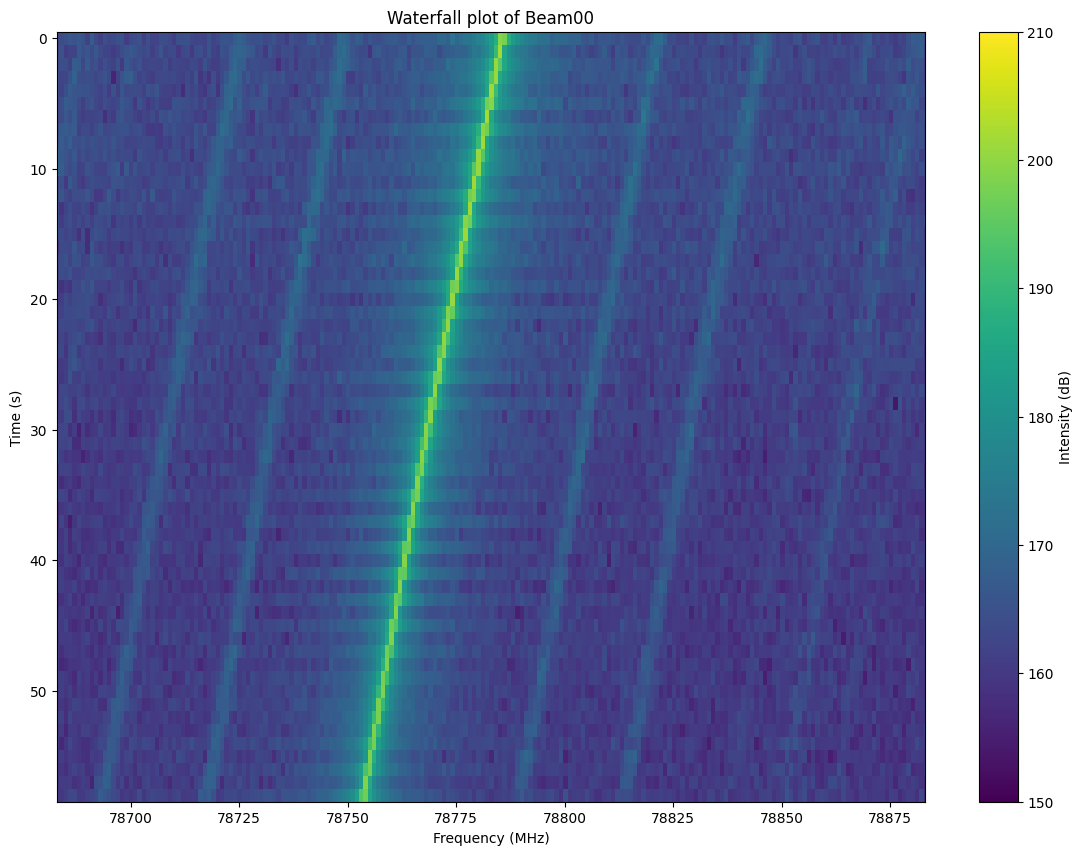

In [19]:
beam00 = '/mnt_blpc3/datax/scratch/jwst-test/guppi_60450_05861_003791_JWST_0001.band01.beam00.h5'
data = load_h5(beam00)

main = find_main_carrier_frequency(data)

plt.figure(figsize=(14, 10))
plt.imshow((10 * np.log10(data)), aspect='auto', cmap='viridis', vmin=150, vmax=210)
plt.xlabel('Frequency (MHz)')
plt.xlim((main -100), (main + 100))
plt.ylabel('Time (s)')
plt.colorbar(label='Intensity (dB)')
plt.title(f'Waterfall plot of Beam00')

## Plot Integrate along the time-axis

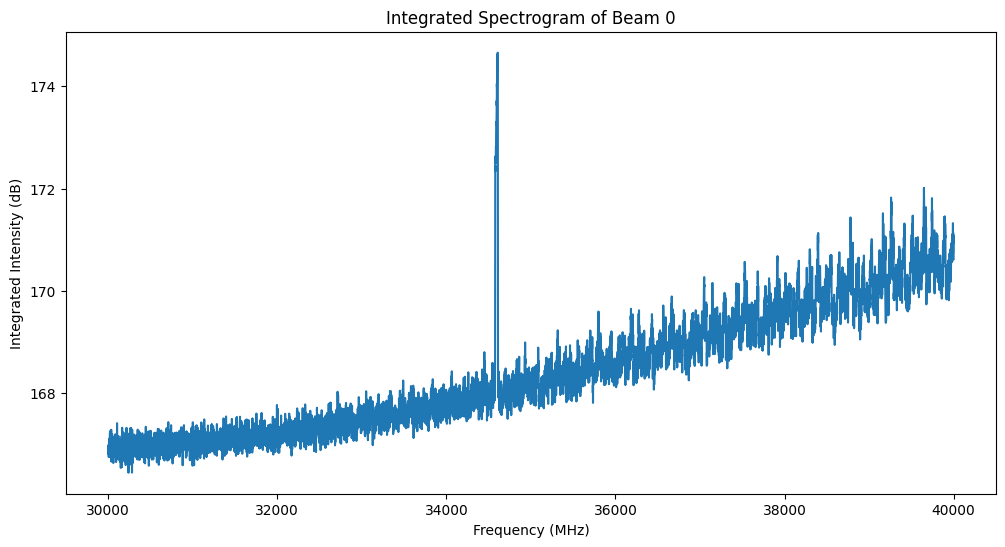

In [20]:
# Select a subset of the data for integration
data = load_h5(beam00)

data_subset = data[0:59, 30000:40000]

# Integrate along the time axis (axis=0)
integrated_data = np.sum(data_subset, axis=0)

# Generate the frequency axis (assuming uniform sampling)
# Replace `start_freq` and `end_freq` with your actual frequency range
start_freq = 30000  # Example start frequency in MHz
end_freq = 40000    # Example end frequency in MHz
freqs = np.linspace(start_freq, end_freq, data_subset.shape[1])

# Plot the integrated data
plt.figure(figsize=(12, 6))
plt.plot(freqs, 10 * np.log10(integrated_data), label='Integrated Intensity')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Integrated Intensity (dB)')
plt.title('Integrated Spectrogram of Beam 0')
plt.show()

## Some hits from certain Beams were not found so the data had to be normalized in order to find it

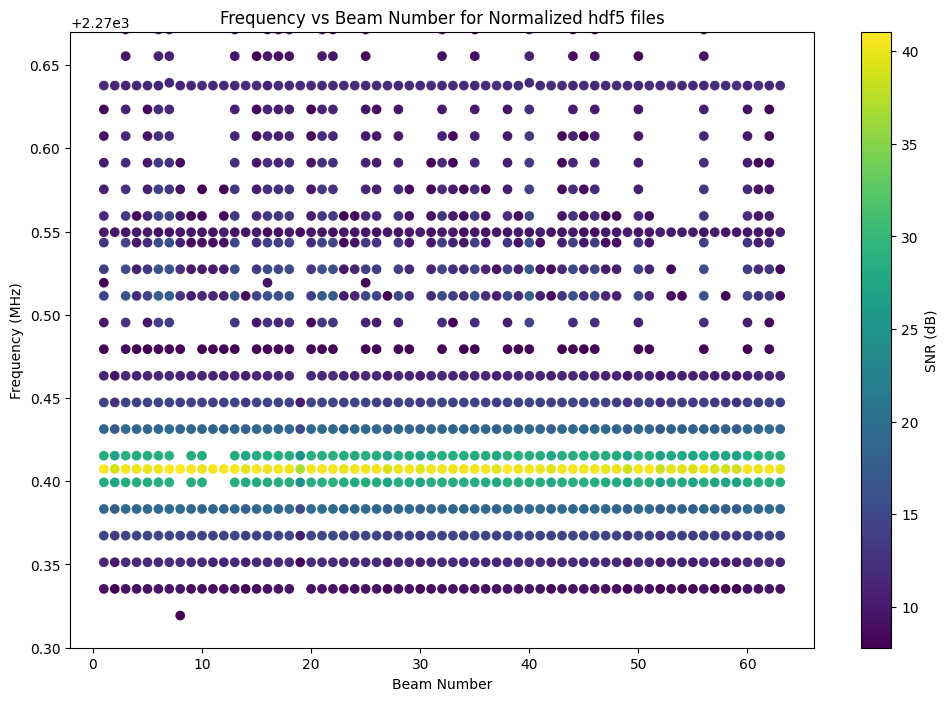

In [21]:
hitsDirectory = '/home/mayalaidler/breakthrough/outputFiles'
mergedNormalizedpd = pd.DataFrame()  # inner, outer, left, right

# Regular expression pattern to find numbers
pattern = re.compile(r'\d+')

# Create the scatter plot
plt.figure(figsize=(12, 8))

# Lists to hold the data for plotting
beam_numbers = []
frequencies = []
snr_values = []

# Initialize a list to store DataFrames
dataframes = []

for file_name in os.listdir(hitsDirectory):
    if file_name.endswith('.hits'):  # Filter files by extension
        file_path = os.path.join(hitsDirectory, file_name)

        # Ensure that we're processing files and not directories
        if os.path.isfile(file_path):
            # Process the file with read_hits function
            
            beam_pattern = re.compile(r'beam(\d+)')
            match = beam_pattern.search(file_name)
            if match:
                beam_number = int(match.group(1))
            else:
                print(f"No beam number found in file name: {file_name}")
                continue
            
            data = read_hits(file_path)
            data['beam'] = beam_number
            
            # Append DataFrame to the list
            dataframes.append(data)
            mergedNormalizedpd = pd.concat(dataframes, ignore_index=True)
            
            # Load in snr and freq values
            file_snr_values = data['snr']
            file_frequencies = data['frequency']
            
            # Normalize the SNR values
            file_snr_values = 10*np.log10(file_snr_values)
            
            # Extract beam number
            numbers = pattern.findall(file_name)
            if 'inco' in file_name:
                beam_number = 'inco'
            elif numbers:
                beam_number = int(numbers[-1])
            else:
                beam_number = 0
            
            # Append the data to the lists
            beam_numbers.extend([beam_number] * len(file_frequencies))
            frequencies.extend(file_frequencies)
            snr_values.extend(file_snr_values)

# Create the scatter plot
scatter = plt.scatter(beam_numbers, frequencies, c=snr_values, cmap='viridis')
plt.ylim(2270.3, 2270.67)
plt.xlabel('Beam Number')
plt.ylabel('Frequency (MHz)')
plt.colorbar(scatter, label='SNR (dB)')
plt.title('Frequency vs Beam Number for Normalized hdf5 files')
plt.show()
